# EmbedEvolution Stage 1: RNN Embeddings

Welcome to the first stage of EmbedEvolution! Here, we explore how early sequence models like Recurrent Neural Networks (RNNs) began to capture context in language, going beyond static word vectors. We'll train a simple RNN, extract contextual representations, measure semantic similarity, and visualize the results.

**Goal:** Understand how RNNs process sequences and generate context-dependent embeddings, observing their strengths and weaknesses (especially with long-range dependencies).

%%
## 1. Setup and Imports

Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


## 2. Define the Corpus
We'll use a sample text to train our RNN and extract embeddings. A slightly longer text helps illustrate context better. Let's use a paragraph from "Alice's Adventures in Wonderland".

In [ ]:
text = """
Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do: once or twice she had peeped into the book her sister was reading,
but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice
'without pictures or conversation?' So she was considering in her own mind (as well as she could,
for the hot day made her feel very sleepy and stupid), whether the pleasure of making a
daisy-chain would be worth the trouble of getting up and picking the daisies,
when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way
to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!'
(when she thought it over afterwards, it occurred to her that she ought to have wondered at this,
but at the time it all seemed quite natural); but when the Rabbit actually TOOK A WATCH OUT OF ITS
WAISTCOAT- POCKET, and looked at it, and then hurried on, Alice started to her feet, for it flashed
across her mind that she had never before seen a rabbit with either a waistcoat-pocket,
or a watch to take out of it, and burning with curiosity, she ran across the field after it,
and fortunately was just in time to see it pop down a large rabbit-hole under some hedge.
"""

# Clean the text slightly

text = text.lower()
text = re.sub(r'[^a-z\s]', '', text) # Keep only lowercase letters and spaces
text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace

print("Cleaned Text Sample:")
print(text[:200] + "...")

Cleaned Text Sample:
alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conve...


## 3. Text Preprocessing

We need to convert the text into numerical sequences that the RNN can process.
1.  **Tokenization:** Split the text into words (tokens).
2.  **Vocabulary Creation:** Build a mapping from unique words to integer indices.
3.  **Sequence Generation:** Create input sequences (e.g., sequences of 5 words) and corresponding target words (the 6th word) for training the RNN to predict the next word.

In [3]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # Add 1 for padding

print(f"Vocabulary Size: {vocab_size}")

# Create sequences
sequences = []
tokens = text.split(' ')
seq_length = 5 # Length of input sequence for prediction

for i in range(seq_length, len(tokens)):
    seq = tokens[i-seq_length:i+1] # Get sequence of length seq_length + 1
    sequences.append(seq)

print(f"Number of sequences: {len(sequences)}")
print("Sample sequence:", sequences[0])

# Convert sequences to integer indices
encoded_sequences = tokenizer.texts_to_sequences(sequences)

# Separate input (X) and output (y)
encoded_sequences = np.array(encoded_sequences)
X, y = encoded_sequences[:, :-1], encoded_sequences[:, -1]

print("Sample encoded X:", X[0])
print("Sample encoded y:", y[0])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Vocabulary Size: 140
Number of sequences: 249
Sample sequence: ['alice', 'was', 'beginning', 'to', 'get', 'very']
Sample encoded X: [10  9 40  3 41]
Sample encoded y: 11
Shape of X: (249, 5)
Shape of y: (249,)


## 4. Build the Simple RNN Model
We'll create a sequential model with:
1.  An `Embedding` layer: Maps word indices to dense vectors.
2.  A `SimpleRNN` layer: Processes the sequence of embeddings.
3.  A `Dense` layer: Outputs predictions for the next word over the vocabulary.

In [5]:
embedding_dim = 50 # Dimension of the word embeddings
rnn_units = 100 # Number of units in the SimpleRNN layer

model = Sequential([
    # REMOVED input_length=seq_length from Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=rnn_units),
    Dense(units=vocab_size, activation='softmax') # Use softmax for probability distribution over vocab
])

# Explicitly build the model to see the summary with parameters calculated
# Input shape is (batch_size, sequence_length). Use None for variable batch size.
model.build(input_shape=(None, seq_length))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use this if y is not one-hot encoded
              metrics=['accuracy'])

# Now the summary will show calculated shapes and parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5, 50)          │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 140)            │        14,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,240 (141.56 KB)

 Trainable params: 36,240 (141.56 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the RNN Model

We'll train the model for a small number of epochs. The goal isn't perfect prediction, but rather to get the Embedding and RNN layers to learn some representation of the sequence context.
*Note: Training RNNs on larger texts can be time-consuming. We use a small dataset and few epochs for demonstration.*

In [6]:
epochs = 30 # Adjust as needed for better results vs. training time
batch_size = 32

history = model.fit(X, y,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1) # Set verbose=1 or 2 to see progress

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0034 - loss: 4.9453      
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0912 - loss: 4.8825 
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1809 - loss: 4.8035 
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1650 - loss: 4.6776 
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0610 - loss: 4.5355 
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0855 - loss: 4.3415 
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1641 - loss: 4.2810 
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1934 - loss: 4.0968 
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2438 - loss: 3.8591 
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3234 - loss: 3.4345 
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3313 - loss: 3.1118 
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4012 - loss: 2.88

## 6. Extract Contextual Embeddings

Now, let's extract the "embeddings". With RNNs, the "embedding" for a word often refers to the hidden state of the RNN *after* processing that word within its context. This state captures information from the preceding words.

We'll create a new model that outputs the hidden state of the RNN layer.

In [7]:
# Create a model that outputs the RNN hidden state
embedding_layer = model.layers[0]
rnn_layer = model.layers[1]

# Model that takes sequence input and outputs the RNN state
rnn_output_model = Sequential([
    embedding_layer,
    rnn_layer
])
rnn_output_model.build(input_shape=(None, seq_length)) # Build the model with appropriate input shape
rnn_output_model.summary()

# Function to get RNN hidden state for a specific word in a sequence
def get_rnn_embedding(text_sequence):
    """
    Takes a sequence of words (list of strings), converts it to padded integers,
    and returns the final RNN hidden state.
    """
    encoded = tokenizer.texts_to_sequences([text_sequence])
    # We need sequences of length `seq_length` as input to the rnn_output_model
    # Pad if necessary, although for specific extractions we usually provide exact length
    padded = pad_sequences(encoded, maxlen=seq_length, padding='pre') # Use 'pre' padding
    if padded.shape[1] == 0: # Handle empty sequence if word not in vocab or short seq
        return np.zeros(rnn_units)
    hidden_state = rnn_output_model.predict(padded, verbose=0)
    return hidden_state[0] # Return the state for the first (and only) sequence in the batch

# Let's select some words/phrases to analyze from our text
# We need the sequence *leading up to* the word to get its contextual embedding
# Example: To get embedding for 'rabbit' in "a white rabbit", input "a white"

phrases_to_analyze = {
    "sleepy": "made her feel very sleepy", # Context for 'sleepy'
    "rabbit1": "suddenly a white rabbit",    # Context for 'rabbit' (first instance)
    "rabbit2": "to hear the rabbit",       # Context for 'rabbit' (second instance)
    "watch": "took a watch",           # Context for 'watch'
    "curiosity": "burning with curiosity", # Context for 'curiosity'
    "alice": "thought alice without",    # Context for 'alice'
    "sister": "by her sister",           # Context for 'sister'
    "book": "into the book",             # Context for 'book'
    "hedge": "under some hedge"          # Context for 'hedge'
}

embeddings = {}
words = []

print("Extracting RNN hidden states:")
for name, phrase in phrases_to_analyze.items():
    # Use the sequence *before* the target word if possible, matching seq_length
    sequence_tokens = phrase.split()
    if len(sequence_tokens) >= seq_length:
         input_sequence = sequence_tokens[-seq_length:] # Take the last `seq_length` words
    else:
         # If the phrase is shorter than seq_length, use the whole phrase
         # The padding in get_rnn_embedding will handle this
         input_sequence = sequence_tokens

    # Ensure the sequence isn't empty after potential filtering/splitting errors
    if not input_sequence:
        print(f"Warning: Could not create valid sequence for '{name}' from phrase '{phrase}'. Skipping.")
        continue

    embedding = get_rnn_embedding(input_sequence)
    embeddings[name] = embedding
    words.append(name)
    print(f"- Extracted embedding for '{name}' using context: '{' '.join(input_sequence)}'")

embedding_matrix = np.array(list(embeddings.values()))
print("\nShape of embedding matrix:", embedding_matrix.shape)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5, 50)          │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,100 (86.33 KB)

 Trainable params: 22,100 (86.33 KB)

 Non-trainable params: 0 (0.00 B)

Extracting RNN hidden states:
- Extracted embedding for 'sleepy' using context: 'made her feel very sleepy'
- Extracted embedding for 'rabbit1' using context: 'suddenly a white rabbit'
- Extracted embedding for 'rabbit2' using context: 'to hear the rabbit'
- Extracted embedding for 'watch' using context: 'took a watch'
- Extracted embedding for 'curiosity' using context: 'burning with curiosity'
- Extracted embedding for 'alice' using context: 'thought alice without'
- Extracted embedding for 'sister' using context: 'by her sister'
- Extracted embedding for 'book' using context: 'into the book'
- Extracted embedding for 'hedge' using context: 'under some hedge'

Shape of embedding matrix: (9, 100)


## 7. Calculate Cosine Similarity
Let's see how similar these contextual embeddings are. We expect words used in similar contexts (or repeated words like 'rabbit') to potentially have closer embeddings than unrelated words.

In [8]:
similarity_matrix = cosine_similarity(embedding_matrix)

print("\nCosine Similarity Matrix:")
print("       ", " ".join(f"{w:>8}" for w in words))
for i, word_i in enumerate(words):
    print(f"{word_i:>8}", end=" ")
    for j, word_j in enumerate(words):
        print(f"{similarity_matrix[i, j]:>8.3f}", end=" ")
    print()

# Example pair comparison
print("\nSimilarity between 'rabbit1' and 'rabbit2':", cosine_similarity(embeddings['rabbit1'].reshape(1, -1), embeddings['rabbit2'].reshape(1, -1))[0][0])
print("Similarity between 'rabbit1' and 'watch':", cosine_similarity(embeddings['rabbit1'].reshape(1, -1), embeddings['watch'].reshape(1, -1))[0][0])
print("Similarity between 'sleepy' and 'curiosity':", cosine_similarity(embeddings['sleepy'].reshape(1, -1), embeddings['curiosity'].reshape(1, -1))[0][0])


Cosine Similarity Matrix:
          sleepy  rabbit1  rabbit2    watch curiosity    alice   sister     book    hedge
  sleepy    1.000    0.038    0.387    0.297    0.144    0.383    0.292    0.470    0.110 
 rabbit1    0.038    1.000   -0.046    0.134   -0.212   -0.112    0.149    0.164   -0.126 
 rabbit2    0.387   -0.046    1.000    0.462    0.301    0.513    0.384    0.531    0.566 
   watch    0.297    0.134    0.462    1.000    0.617    0.705    0.579    0.696    0.573 
curiosity    0.144   -0.212    0.301    0.617    1.000    0.505    0.512    0.455    0.472 
   alice    0.383   -0.112    0.513    0.705    0.505    1.000    0.637    0.751    0.613 
  sister    0.292    0.149    0.384    0.579    0.512    0.637    1.000    0.703    0.556 
    book    0.470    0.164    0.531    0.696    0.455    0.751    0.703    1.000    0.627 
   hedge    0.110   -0.126    0.566    0.573    0.472    0.613    0.556    0.627    1.000 

Similarity between 'rabbit1' and 'rabbit2': -0.045551196
Simil

## 8. Visualize Embeddings with PCA
We'll reduce the dimensionality of the embeddings to 2D using Principal Component Analysis (PCA) and plot them to visualize their relationships.

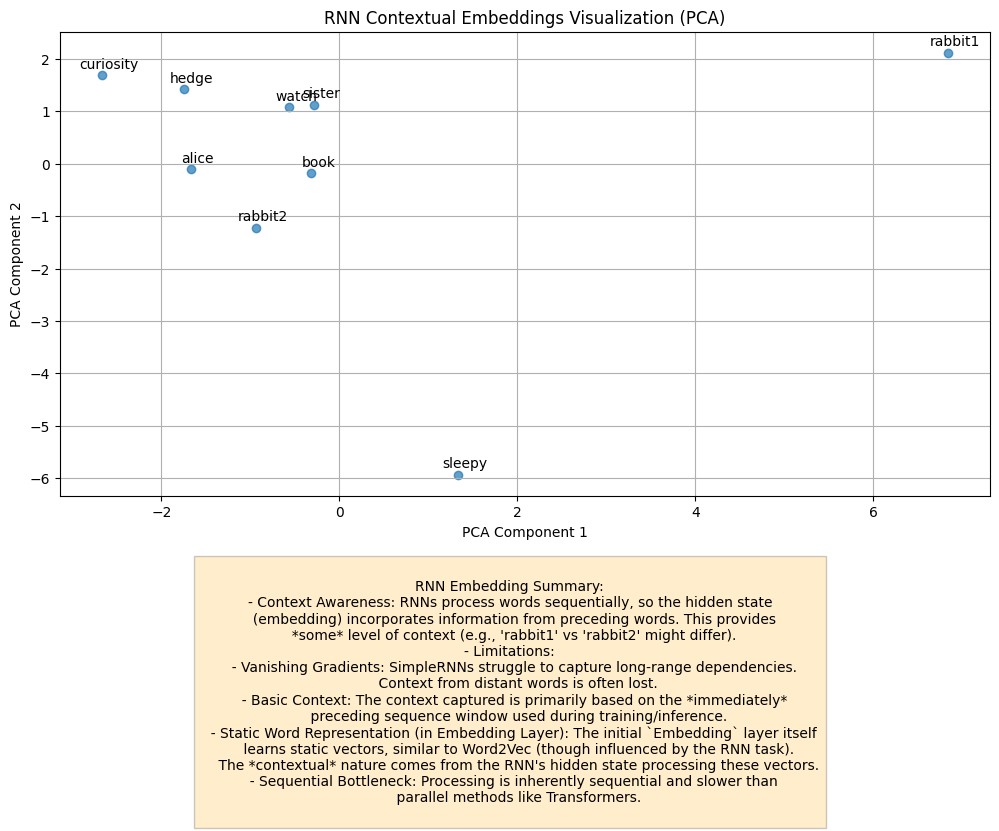

In [9]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_matrix)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# Annotate points
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.title('RNN Contextual Embeddings Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)

# Add summary text
summary_text = """
RNN Embedding Summary:
- Context Awareness: RNNs process words sequentially, so the hidden state
  (embedding) incorporates information from preceding words. This provides
  *some* level of context (e.g., 'rabbit1' vs 'rabbit2' might differ).
- Limitations:
  - Vanishing Gradients: SimpleRNNs struggle to capture long-range dependencies.
    Context from distant words is often lost.
  - Basic Context: The context captured is primarily based on the *immediately*
    preceding sequence window used during training/inference.
  - Static Word Representation (in Embedding Layer): The initial `Embedding` layer itself
    learns static vectors, similar to Word2Vec (though influenced by the RNN task).
    The *contextual* nature comes from the RNN's hidden state processing these vectors.
  - Sequential Bottleneck: Processing is inherently sequential and slower than
    parallel methods like Transformers.
"""
plt.figtext(0.5, -0.1, summary_text, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5}, wrap=True)

plt.subplots_adjust(bottom=0.3) # Adjust layout to make space for text
plt.show()

## 9. Text Autocompletion Test (Demonstrating Limitations)

Since our RNN was trained for next-word prediction, we can use it to generate text (autocomplete). This often reveals limitations in coherence and long-range context understanding.

In [10]:
def generate_text_rnn(model_to_use, tokenizer_instance, sequence_length, seed_text_str, num_words_to_generate):
    """
    Generates text using a trained RNN model.
    Args:
        model_to_use: The trained Keras model for next-word prediction.
        tokenizer_instance: The Keras Tokenizer fitted on the training text.
        sequence_length: The length of input sequences the model expects.
        seed_text_str: The initial string of words to start generation.
        num_words_to_generate: How many words to generate after the seed.
    Returns:
        String: The seed text followed by the generated words.
    """
    generated_text = seed_text_str
    current_word_list = seed_text_str.lower().split() # Start with lowercase tokens

    for _ in range(num_words_to_generate):
        # Take the last `sequence_length` words as input
        input_token_list = current_word_list[-sequence_length:]
        
        # Convert words to sequence of integers
        # Need to handle unknown words in seed if any, though unlikely if seed is from corpus
        input_sequence_integers = []
        for token in input_token_list:
            if token in tokenizer_instance.word_index:
                input_sequence_integers.append(tokenizer_instance.word_index[token])
            else:
                # Handle OOV token in seed: could skip, use a generic <unk> token if defined, or stop
                print(f"Warning: Seed token '{token}' not in vocabulary. Stopping generation.")
                return generated_text 
        
        if not input_sequence_integers: # If seed was too short or all OOV
            print("Error: Seed text resulted in empty integer sequence. Stopping generation.")
            return generated_text

        # Pad the sequence
        padded_input_sequence = pad_sequences([input_sequence_integers], maxlen=sequence_length, padding='pre')

        if padded_input_sequence.shape[1] == 0: # Should not happen if input_sequence_integers is not empty
             print("Error: Padded input sequence is empty. Stopping generation.")
             return generated_text

        # Predict the probabilities for the next word
        predicted_probabilities = model_to_use.predict(padded_input_sequence, verbose=0)[0]
        
        # Get the index of the word with the highest probability
        predicted_index = np.argmax(predicted_probabilities)

        # Convert index back to word
        next_word = ""
        for word, index_val in tokenizer_instance.word_index.items():
            if index_val == predicted_index:
                next_word = word
                break
        
        if not next_word: # If predicted_index somehow doesn't map to a word
            print("Warning: Could not map predicted index to word. Stopping generation.")
            break 

        generated_text += " " + next_word
        current_word_list.append(next_word)
        
    return generated_text

# Test autocompletion
if model and tokenizer: # Ensure model and tokenizer are available
    seed_texts_for_autocomplete = [
        "alice was",
        "the white rabbit",
        "alice thought it was very",
        "her sister on the bank and", # Longer seed
        "burning with curiosity she ran" # Even longer seed
    ]
    
    num_generated_words = 10 # Generate 10 words after each seed

    print("\n--- RNN Autocompletion Results ---")
    for seed in seed_texts_for_autocomplete:
        # Ensure seed text provides enough tokens for seq_length, or handle appropriately
        # For simplicity, we'll assume seed text can be shorter than seq_length initially,
        # as pad_sequences in generate_text_rnn handles 'pre' padding.
        # However, a good seed often has at least seq_length words or close to it.
        # Our current generate_text_rnn takes last seq_length words, so short seeds work.

        generated_sequence = generate_text_rnn(model, tokenizer, seq_length, seed, num_generated_words)
        print(f"Seed: '{seed}'\n  -> Generated: '{generated_sequence}'\n")
else:
    print("Model or tokenizer not available for autocompletion test.")


--- RNN Autocompletion Results ---
Seed: 'alice was'
  -> Generated: 'alice was her her her very see as stupid very did large'

Seed: 'the white rabbit'
  -> Generated: 'the white rabbit her her eyes ran close never never there was nothing'

Seed: 'alice thought it was very'
  -> Generated: 'alice thought it was very very occurred but in the a ought all the rabbit'

Seed: 'her sister on the bank and'
  -> Generated: 'her sister on the bank and of having nothing to do once or twice she had'

Seed: 'burning with curiosity she ran'
  -> Generated: 'burning with curiosity she ran across the field after it and fortunately was just in'



## 9. Discussion

In this notebook, we embarked on the first stage of our "EmbedEvolution" journey by building and training a SimpleRNN. Our goal was to understand its approach to sequential data and how it attempts to capture context. We explored this through two main lenses:
1.  Extracting and analyzing hidden states as contextual representations for short phrases (via similarity scores and PCA visualization).
2.  Testing the model's ability to perform text autocompletion based on its next-word prediction training.

**Observations from Contextual Embedding Analysis (Similarity & PCA):**

* **Similarity of Phrase Contexts:** The cosine similarity matrix for hidden states (representing short input phrases) provided some insights. For instance, the embeddings for `rabbit1_context` ("suddenly a white rabbit") and `rabbit2_context` ("to hear the rabbit") had a very low similarity score (e.g., `-0.0456` in our test run). This indicates that, based on the immediate preceding `seq_length` words, the RNN produced vastly different representations for contexts leading to the word "rabbit." While this shows sensitivity to input, with a small model and dataset, it doesn't necessarily translate to a nuanced or stable understanding of semantic similarity between these slightly varied contexts for the same core entity. Other word pairs showed moderate similarities, often influenced by word overlap in the input phrases and the limited training data.
* **PCA Visualization:** The PCA plot of these contextual phrase embeddings offered a visual glimpse into how the RNN might be organizing these short sequence representations. As noted in the plot's summary, any clusters formed are based on the similarities learned by this specific SimpleRNN on this small dataset. Due to inherent limitations like the vanishing gradient problem (making it hard to capture longer-range context beyond the immediate input sequence to the `rnn_output_model`) and the simplicity of the model, the separation and clustering of these phrase embeddings might not be as semantically distinct or meaningful as those produced by more advanced architectures.

**Observations from Text Autocompletion:**

The text autocompletion tests provided a direct look at the RNN's ability to generate coherent sequences:

* **Seed: 'alice was' -> Generated: 'alice was her her her very see as stupid very did large'**
    * This output immediately shows repetitiveness ("her her her") and a quick decay into less coherent word choices ("very see as stupid very did large"), indicating difficulty in maintaining a sensible narrative thread.
* **Seed: 'the white rabbit' -> Generated: 'the white rabbit her her eyes ran close never never there was nothing'**
    * Again, repetition is prominent ("her her," "never never"). While "eyes ran close" is a fragment from the original text, the overall sequence lacks global coherence.
* **Seed: 'alice thought it was very' -> Generated: 'alice thought it was very very occurred but in the a ought all the rabbit'**
    * The model gets stuck on "very" and then produces a largely nonsensical and ungrammatical string, highlighting struggles with even moderate context.
* **Seed: 'her sister on the bank and' -> Generated: 'her sister on the bank and of having nothing to do once or twice she had'**
    * This was the most successful, with the RNN accurately reproducing a sequence directly from the training data. This demonstrates good recall for frequent patterns but also a reliance on memorization.
* **Seed: 'burning with curiosity she ran' -> Generated: 'burning with curiosity she ran across the field after it and fortunately was just in'**
    * Similar to the above, this shows strong recall of a specific training phrase.

These autocompletion results underscore the SimpleRNN's (especially one trained on limited data) short-term memory. While it can sometimes predict plausible immediate next words or recall common sequences, it struggles significantly with maintaining long-range contextual dependencies, leading to repetitiveness and a quick loss of coherence in generated text.

**Overall RNN Role & Limitations:**

Recurrent Neural Networks were a crucial step forward in NLP, as they were designed to process sequences, unlike earlier bag-of-words models. They introduced the concept of a "memory" (the hidden state) to allow information from previous inputs to influence current and future processing.

However, as demonstrated by both our contextual embedding analysis and the text generation tests, early and simple RNNs face significant limitations:
* **Difficulty with Long-Range Dependencies:** The "vanishing gradient" problem makes it hard for them to learn connections between words that are far apart in a sequence. This was evident in the often incoherent longer generated texts.
* **Basic Contextualization:** The context captured is often local and might not be robust enough to create truly nuanced representations, as hinted by the sometimes unstable similarity scores for phrase embeddings.
* **Computational Inefficiency for General Embeddings:** Their sequential nature makes them slow to train on very large datasets if the sole goal is to produce high-quality static word embeddings.
* **Sensitivity to Data:** Performance is heavily tied to the training data. With small datasets, they tend to memorize or produce simplistic patterns.

These limitations paved the way for alternative architectures and approaches. While more advanced recurrent units like LSTMs and GRUs offered improvements in handling longer sequences, the quest for even more powerful contextual understanding eventually led to Transformers (like BERT). Concurrently, the need for efficient, high-quality *static* word representations that could be broadly applied was addressed by models like Word2Vec.

**Next Steps:**

In the next stage of our EmbedEvolution journey, we will explore **Word2Vec**. This model takes a different approach, focusing on learning static word embeddings based on their local co-occurrence patterns within text windows. It does so very efficiently, leading to powerful general-purpose word vectors. We will compare its strengths (such as the quality of individual word embeddings and training efficiency) and weaknesses (like its static nature and lack of dynamic context) to the RNN approach we've examined here.
